In [1]:
import QuantLib as ql
today = ql.Date(20, 6, 2025)
ql.Settings.instance().evaluationDate = today

calendar   = ql.NullCalendar()          # << every day is “good’’
dayCounter = ql.Actual365Fixed()

In [19]:
import numpy as np
def read_vol_data(path):
    data = np.load(path)
    print("Keys in the loaded data:", data.keys())

    quote_dates = data['quote_dates']
    vol_surfaces = data['vol_surfaces']
    k_grid = data['k_grid']
    T_grid = data['T_grid']
    K_grid = np.exp(k_grid)  # Convert log-strike grid to strike grid with S0=1

    return data, quote_dates, vol_surfaces, K_grid, T_grid

data, quote_dates, vol_surfaces, K_grid, T_grid = read_vol_data("../data_process/data_pack/SPX_vol_surface_train.npz")

print("Data loaded successfully.")
# Example of how to use the loaded data
print("Quote Dates:", quote_dates)
print("vol Surfaces Shape:", vol_surfaces.shape)
print("K Grid Shape:", K_grid.shape)
print("T Grid Shape:", T_grid.shape)
print("K Grid:", K_grid)
print("T Grid:", T_grid)
print("First vol Surface:", vol_surfaces[0])  # Print the first vol surface for inspectio


Keys in the loaded data: KeysView(NpzFile '../data_process/data_pack/SPX_vol_surface_train.npz' with keys: quote_dates, vol_surfaces, k_grid, T_grid)
Data loaded successfully.
Quote Dates: ['2020-02-05' '2023-03-24' '2019-09-27' ... '2018-08-23' '2018-01-26'
 '2022-06-27']
vol Surfaces Shape: (1164, 20, 41)
K Grid Shape: (41,)
T Grid Shape: (20,)
K Grid: [0.74081822 0.75201425 0.76337949 0.7749165  0.78662786 0.79851622
 0.81058425 0.82283466 0.83527021 0.8478937  0.86070798 0.87371591
 0.88692044 0.90032452 0.91393119 0.92774349 0.94176453 0.95599748
 0.97044553 0.98511194 1.         1.01511306 1.03045453 1.04602786
 1.06183655 1.07788415 1.09417428 1.11071061 1.12749685 1.14453678
 1.16183424 1.17939312 1.19721736 1.21531099 1.23367806 1.25232272
 1.27124915 1.29046162 1.30996445 1.32976203 1.34985881]
T Grid: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
First vol Surface: [[0.39536716 0.38801333 0.38032872 0.37238134 0.3643579

K Grid Shape: (41,)
T Grid Shape: (20,)
T Mesh shape: (20, 41)
K Mesh shape: (20, 41)
first vol Surface shape: (20, 41)


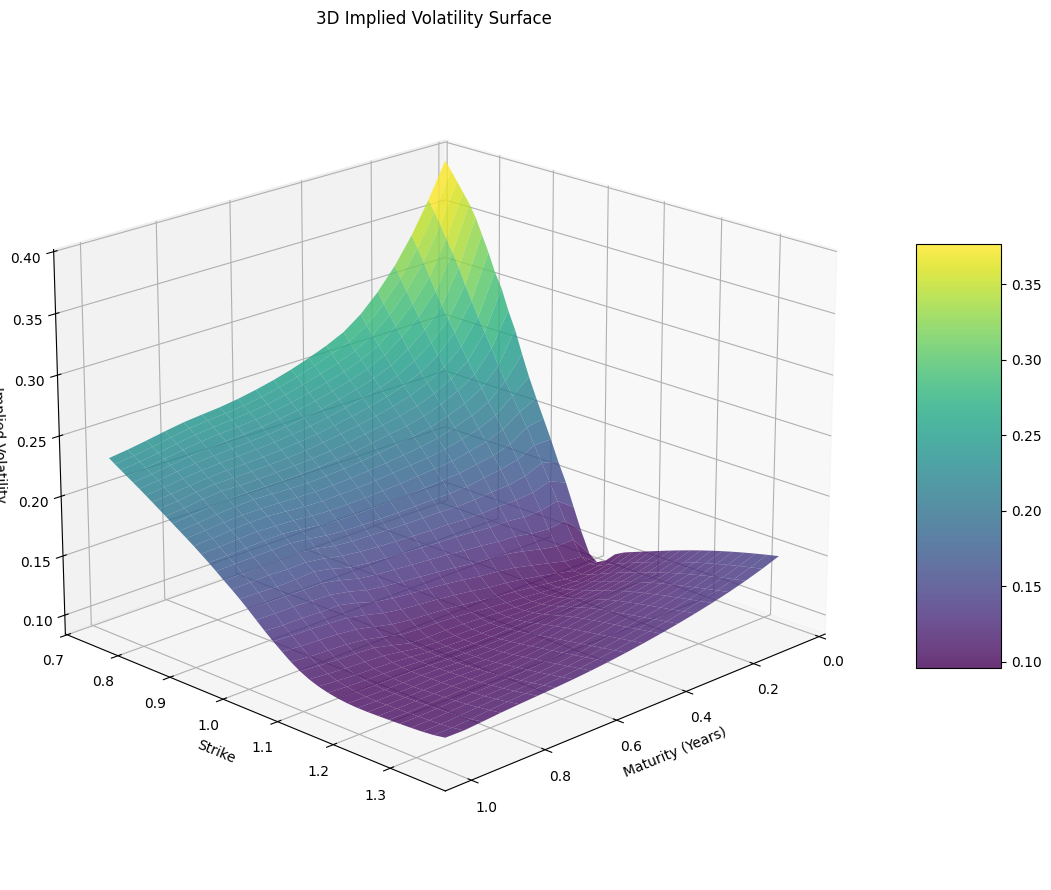

NameError: name 'inspection' is not defined

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid for 3D plotting
K_mesh,T_mesh = np.meshgrid(K_grid, T_grid)
first_vol_surface = vol_surfaces[0]  # Use the first surface for demonstration
print("K Grid Shape:", K_grid.shape)
print("T Grid Shape:", T_grid.shape)
print("T Mesh shape:", T_mesh.shape)
print("K Mesh shape:", K_mesh.shape)
print("first vol Surface shape:", first_vol_surface.shape)  # Print the first vol surface for

# Create 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(T_mesh, K_mesh, first_vol_surface,
                       cmap='viridis', alpha=0.8, edgecolor='none')

# Add labels and title
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Volatility')
ax.set_title('3D Implied Volatility Surface')

# Add colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
from scipy.interpolate import PchipInterpolator
def fix_vol_surface(K_grid, T_grid, vols,
                    *, calendar_fix=True, smooth_strikes=True):
    """
    Clean a raw implied-volatility matrix.

    Parameters
    ----------
    K_grid : 1-d array-like (N_K,)        – strikes  (must be ascending)
    T_grid : 1-d array-like (N_T,)        – maturities in years (ascending)
    vols   : 2-d array-like (N_K, N_T)    – σ_imp(K,T)
    calendar_fix   : bool, default=True   – enforce w(K,T) non-decreasing in T
    smooth_strikes : bool, default=True   – PCHIP smoothing along strikes

    Returns
    -------
    vols_fixed : ndarray (N_K, N_T)       – repaired surface, same shape as input
    """
    K_grid = np.asarray(K_grid, dtype=float)
    T_grid = np.asarray(T_grid, dtype=float)
    vols   = np.asarray(vols,   dtype=float).copy()      # work on a copy

    if vols.shape != (K_grid.size, T_grid.size):
        raise ValueError("vols must have shape (len(K_grid), len(T_grid))")

    # ------------------------------------------------------------------
    # 1) Calendar-time monotonicity: w(K,T)=σ²T must rise with T
    # ------------------------------------------------------------------
    if calendar_fix:
        w = vols**2 * T_grid[np.newaxis, :]              # total variance
        for j in range(1, w.shape[1]):
            bad = w[:, j] < w[:, j-1]
            if np.any(bad):
                w[bad, j] = w[bad, j-1]                  # lift offending nodes
        vols = np.sqrt(w / T_grid[np.newaxis, :])

    # ------------------------------------------------------------------
    # 2) Strike-by-strike smoothing with PCHIP (preserves shape, no overshoot)
    # ------------------------------------------------------------------
    if smooth_strikes:
        for j in range(T_grid.size):
            pchip = PchipInterpolator(K_grid, vols[:, j], extrapolate=True)
            vols[:, j] = pchip(K_grid)

    return vols

In [8]:
# build arbitrage-free surface

def build_andreasen_huge_surface(
        K_grid, T_grid, vols,
        spot,
        r_flat = 0.02,           # risk-free continuously-compounded rate
        q_flat = 0.00,           # dividend / repo / foreign rate
        *,
        today      = None,
        calendar   = ql.NullCalendar(),
        dayCounter = ql.Actual365Fixed()):
    """
    Return a BlackVolTermStructureHandle backed by an Andreasen–Huge
    arbitrage-free adapter, *without* requiring pre-built rTS/qTS.

    Parameters
    ----------
    K_grid, T_grid, vols : smile grid (σ_imp)
    spot      : current spot price (float)
    r_flat    : flat risk-free rate  (annualised, cc)
    q_flat    : flat dividend / repo rate
    today     : evaluation date (ql.Date or None → ql.Settings date)
    calendar  : QuantLib calendar for expiries (default NullCalendar)
    dayCounter: QuantLib day-count convention (default Actual/365)

    Returns
    -------
    ql.BlackVolTermStructureHandle  (arbitrage-free)
    """

    # ---------------- dates & curves ---------------------------------
    if today is None:
        today = ql.Settings.instance().evaluationDate
    elif isinstance(today, ql.Date):
        ql.Settings.instance().evaluationDate = today
    else:
        raise TypeError("today must be a QuantLib Date or None")

    rTS = ql.YieldTermStructureHandle(
              ql.FlatForward(today, r_flat, dayCounter))
    qTS = ql.YieldTermStructureHandle(
              ql.FlatForward(today, q_flat, dayCounter))

    # ---------------- load vol matrix --------------------------------
    volMatrix = ql.Matrix(len(K_grid), len(T_grid))
    for i in range(len(K_grid)):
        for j in range(len(T_grid)):
            volMatrix[i][j] = vols[i, j]

    expiries = [ today + int(t*365 + 0.5) for t in T_grid ]
    rawSurf  = ql.BlackVarianceSurface(today, calendar,
                                       expiries, K_grid, volMatrix,
                                       dayCounter)
    rawSurf.enableExtrapolation()

    # ---------------- Andreasen–Huge adapter -------------------------
    spotHandle = ql.QuoteHandle(ql.SimpleQuote(spot))

    ah_interp  = ql.AndreasenHugeVolatilityInterpl(rawSurf,
                                                   spotHandle,
                                                   rTS, qTS)
    blackSurf_AH = ql.AndreasenHugeVolatilityAdapter(ah_interp)
    blackSurf_AH.enableExtrapolation()

    return ql.BlackVolTermStructureHandle(blackSurf_AH)

vol_surfaces shape: (20, 41)
41 20 (20, 41)
volMatrix shape: 41 x 20


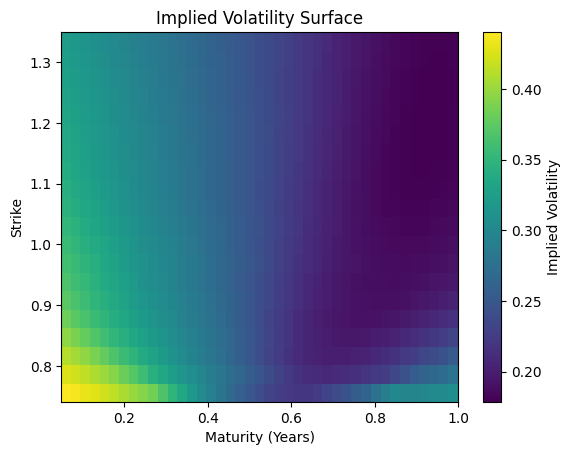

All values in the volatility surface are non-negative.


In [29]:
volMatrix = ql.Matrix(len(K_grid), len(T_grid))
print("vol_surfaces shape:", vol_surfaces[-1].shape)
vols = vol_surfaces[-1]  # Use the first surface for demonstration
#vols = np.transpose(vol_surfaces[-1])  # Use the first surface for demonstration
#vols = fix_vol_surface(K_grid, T_grid, vols, calendar_fix=True, smooth_strikes=True)

print(len(K_grid), len(T_grid), vols.shape)
print(f"volMatrix shape: {volMatrix.rows()} x {volMatrix.columns()}")
import matplotlib.pyplot as plt
plt.imshow(vols, aspect='auto', origin='lower',
           extent=[T_grid[0], T_grid[-1], K_grid[0], K_grid[-1]])
plt.colorbar(label='Implied Volatility')
plt.xlabel('Maturity (Years)')
plt.ylabel('Strike')
plt.title('Implied Volatility Surface')
plt.show()

if np.any(vols < 0):
    print("There are negative values in the volatility surface.")
else:
    print("All values in the volatility surface are non-negative.")

for i in range(len(K_grid)): # K -s 41
    for j in range(len(T_grid)): # (T is 20)
        volMatrix[i][j] = vols[j, i] # vols is (20x41)

expiry_dates = [today + int(t*365 + 0.5) for t in T_grid]
blackSurf = ql.BlackVarianceSurface(today, ql.NullCalendar() ,expiry_dates, K_grid,
                                        volMatrix, dayCounter)

blackSurf.enableExtrapolation()
volTS = ql.BlackVolTermStructureHandle(blackSurf)

In [30]:
volTS.enableExtrapolation()

In [28]:
# Workaround Block: Define and implement the NoExceptLocalVolSurface to handle potential arbitrage points

class NoExceptLocalVolSurface(ql.LocalVolSurface):
    def __init__(self, black_vol_ts, risk_free_ts, dividend_ts, spot_handle, illegal_local_vol_overwrite):
        super(NoExceptLocalVolSurface, self).__init__(black_vol_ts, risk_free_ts, dividend_ts, spot_handle, 1e-8)  # drifter parameter for numerical stability
        self._illegal_local_vol_overwrite = illegal_local_vol_overwrite

    def localVolImpl(self, time, strike):
        try:
            return super().localVolImpl(time, strike)
        except RuntimeError as e:
            # Optionally: print(f"Arbitrage point detected at time={time}, strike={strike}: {e}")
            return self._illegal_local_vol_overwrite

# Assume or define necessary parameters (adjust if already defined in your notebook)
spot_price = 1.0  # Example spot price, adjust to your S0
risk_free_rate = 0.02  # Example risk-free rate
dividend_yield = 0.0  # Example dividend yield (set to 0 if no dividends)
day_counter = ql.Actual365Fixed()  # Assume day_counter if not defined; use your dayCounter
today = ql.Date(16, ql.July, 2025)  # If not already set

spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))

risk_free_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, risk_free_rate, day_counter))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, dividend_yield, day_counter))

# Create the NoExceptLocalVolSurface with a fallback volatility (e.g., 20%)
fallback_vol = 0.20
local_vol_surface = NoExceptLocalVolSurface(volTS, risk_free_ts, dividend_ts, spot_handle, fallback_vol)

# Create the process using the custom local vol surface
local_vol_handle = ql.LocalVolTermStructureHandle(local_vol_surface)
process = ql.BlackScholesMertonProcess(spot_handle, dividend_ts, risk_free_ts, volTS, local_vol_handle)

TypeError: new_LocalVolSurface expected at most 4 arguments, got 5
Additional information:
Wrong number or type of arguments for overloaded function 'new_LocalVolSurface'.
  Possible C/C++ prototypes are:
    LocalVolSurface::LocalVolSurface(Handle< BlackVolTermStructure > const &,Handle< YieldTermStructure > const &,Handle< YieldTermStructure > const &,Handle< Quote > const &)
    LocalVolSurface::LocalVolSurface(Handle< BlackVolTermStructure > const &,Handle< YieldTermStructure > const &,Handle< YieldTermStructure > const &,Real)


In [ ]:
S0, r, q = 1, 0.02, 0.0
spot     = ql.QuoteHandle(ql.SimpleQuote(S0))
ratesTS  = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dayCounter))
divTS    = ql.YieldTermStructureHandle(ql.FlatForward(today, q, dayCounter))

process  = ql.BlackScholesMertonProcess(spot, divTS, ratesTS, volTS)
engine = ql.FdBlackScholesVanillaEngine(process, 200,400)

T = 180/365                             # 6-month put, K = 1.05
maturity = today + int(T*365 + 0.5)     # no holidays, just add days
payoff   = ql.PlainVanillaPayoff(ql.Option.Put, 1.09)
exercise = ql.AmericanExercise(today, maturity)
option   = ql.VanillaOption(payoff, exercise)

option.setPricingEngine(engine)
print("NPV =", option.NPV())

NPV = 0.11049382715745147


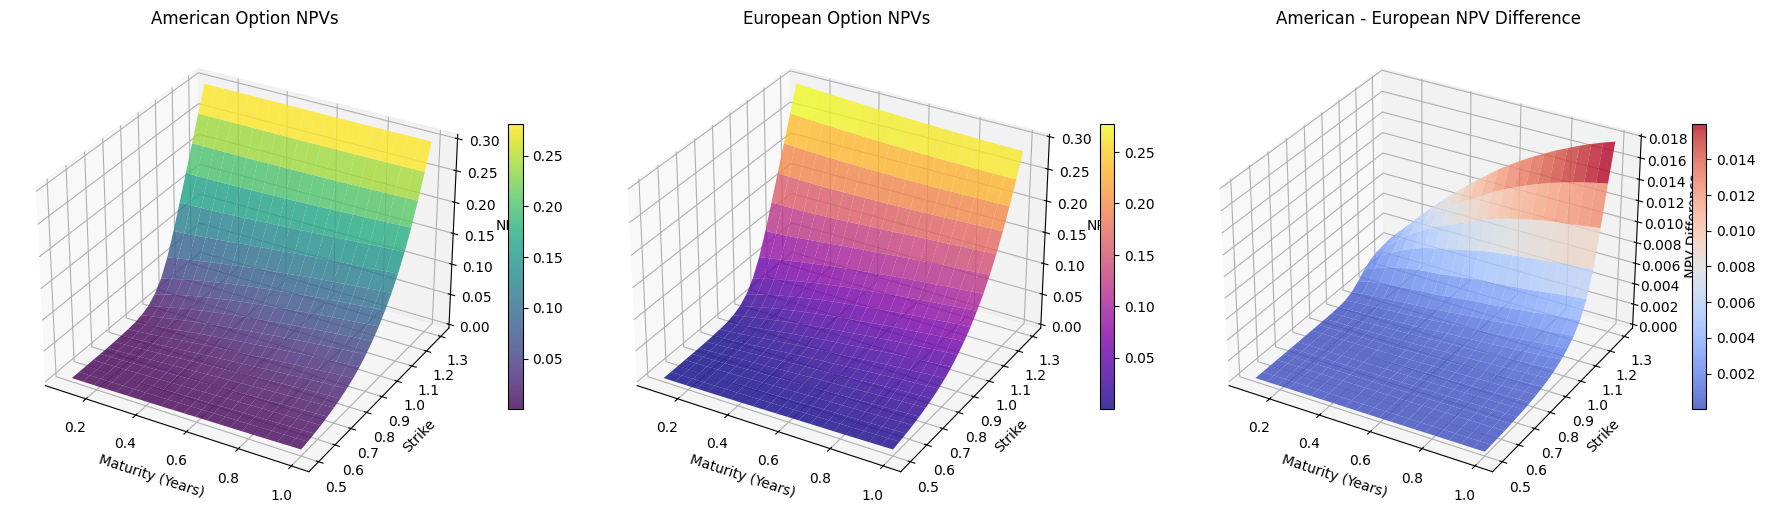

In [46]:

maturity = today + int(T*365 + 0.5)     # no holidays, just add days
Ks = np.linspace(0.5, 1.3, 21)
Ts = np.linspace(0.1,1.0, 21)
ANPVs = np.zeros((len(Ks), len(Ts)))
ENPVS = np.zeros((len(Ks), len(Ts)))
for i in range(len(Ks)):
    for j in range(len(Ts)):
        K = Ks[i]
        T = Ts[j]
        maturity = today + int(T*365 + 0.5)     # no holidays
        Aoption   = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Put, K), ql.AmericanExercise(today, maturity))
        Aoption.setPricingEngine(engine)
        ANPVs[i][j] = Aoption.NPV()
        Eoption = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Put, K), ql.EuropeanExercise(maturity))
        Eoption.setPricingEngine(engine)
        ENPVS[i][j] = Eoption.NPV()

# Create 3D plots for ANPVs, ENPVs, and their difference
fig = plt.figure(figsize=(18, 6))
# Create meshgrid for 3D plotting
K_mesh, T_mesh = np.meshgrid(Ks, Ts)
# Plot 1: American Option NPVs
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(T_mesh, K_mesh, ANPVs.T, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Maturity (Years)')
ax1.set_ylabel('Strike')
ax1.set_zlabel('NPV')
ax1.set_title('American Option NPVs')
fig.colorbar(surf1, ax=ax1, shrink=0.5)
# Plot 2: European Option NPVs
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(T_mesh, K_mesh, ENPVS.T, cmap='plasma', alpha=0.8)
ax2.set_xlabel('Maturity (Years)')
ax2.set_ylabel('Strike')
ax2.set_zlabel('NPV')
ax2.set_title('European Option NPVs')
fig.colorbar(surf2, ax=ax2, shrink=0.5)
# Plot 3: Difference (American - European)
ax3 = fig.add_subplot(133, projection='3d')
diff_surface = ANPVs - ENPVS
surf3 = ax3.plot_surface(T_mesh, K_mesh, diff_surface.T, cmap='coolwarm', alpha=0.8)
ax3.set_xlabel('Maturity (Years)')
ax3.set_ylabel('Strike')
ax3.set_zlabel('NPV Difference')
ax3.set_title('American - European NPV Difference')
fig.colorbar(surf3, ax=ax3, shrink=0.5)
plt.tight_layout()
plt.show()

In [ ]:

# 2 .  Build the no-arb surface with flat curves 2% / 0%:
#volTS = build_andreasen_huge_surface(K_grid, T_grid, vols, spot      = 1.0, r_flat    = 0.02, q_flat    = 0.00)
#print("Andreasen-Huge surface built.", volTS)

# 3 .  Pricing engine (local-vol flagged True):

process = ql.BlackScholesMertonProcess(
              ql.QuoteHandle(ql.SimpleQuote(1.0)),
              ql.YieldTermStructureHandle(
                    ql.FlatForward(ql.Settings.instance().evaluationDate,
                                   0.00, ql.Actual365Fixed())),
              ql.YieldTermStructureHandle(
                    ql.FlatForward(ql.Settings.instance().evaluationDate,
                                   0.02, ql.Actual365Fixed())),
              volTS)

engine = ql.FdBlackScholesVanillaEngine(process,
                                        tGrid = 200, xGrid = 400,
                                        localVol = True)

option.setPricingEngine(engine)
print("NPV =", option.NPV())

TypeError: FdBlackScholesVanillaEngine.__init__() got an unexpected keyword argument 'tGrid'

In [25]:
# works with QuantLib ≥ 1.30  (all params are positional)
engine = ql.FdBlackScholesVanillaEngine(
            process,        # Black-Scholes-MertonProcess
            200,            # tGrid      – time steps
            200,            # xGrid      – asset-price grid points
            0,              # dampingSteps
            ql.FdmSchemeDesc.CrankNicolson(),  # scheme
            True)           # localVol   – let the engine build Dupire σloc

option.setPricingEngine(engine)

print("NPV =", option.NPV())

RuntimeError: decreasing variance at strike 1.68814 between time 0.491918 and time 0.492018